# Titanic Challenge

In [1]:
# import sys
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install sklearn

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle/input/titanic/test.csv
kaggle/input/titanic/titanic.zip
kaggle/input/titanic/train.csv
kaggle/input/titanic/gender_submission.csv


### Look for columns with missing values

In [3]:
t_train_orig = pd.read_csv("kaggle/input/titanic/train.csv")
t_train_orig.name = "Titanic Training Set"
t_test_orig = pd.read_csv("kaggle/input/titanic/test.csv")
t_test_orig.name = "Titanic Test Set"

def display_missing(df):    
    for col in df.columns.tolist(): 
        if df[col].isnull().sum() > 0:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')

dfs = [t_train_orig, t_test_orig]

for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Titanic Training Set
Age column missing values: 177
Cabin column missing values: 687
Embarked column missing values: 2


Titanic Test Set
Age column missing values: 86
Fare column missing values: 1
Cabin column missing values: 327




###  Women were much more likely to survive than men

In [4]:
t_train_orig['Died']= t_train_orig['Survived'].map(lambda survived: 0 if survived == 1 else 1)
t_train_orig.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked='true')

### There's a correlation between ticket price and the likelihood of survival

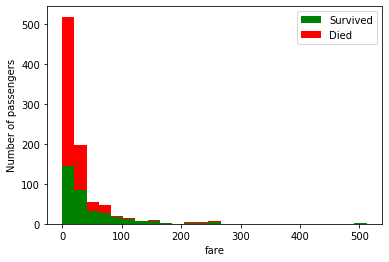

In [5]:
import matplotlib.pyplot as plt
t = t_train_orig
fare_survived =t[t['Survived'] == 1]['Fare'] 
fare_died = t[t['Survived'] == 0]['Fare'] 
plt.hist([fare_survived, fare_died], stacked=True, color = ['g', 'r'], 
         bins = 25, label=['Survived', 'Died'])
plt.xlabel('fare')
plt.ylabel('Number of passengers')
plt.legend()

### Survival  is correlated best with class and fare
so we can fill in nulls with more representative values

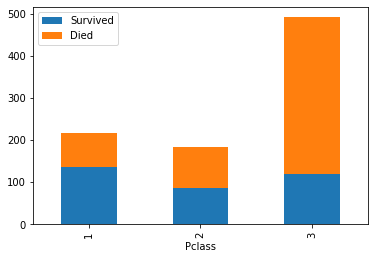

In [6]:
t_train_corr = t_train_orig.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
t_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)

groups = t_train_corr[(0.1 < t_train_corr["Correlation Coefficient"]) & (t_train_corr["Correlation Coefficient"] < .85)].groupby('Feature 1')
groups.get_group('Survived')

t_train_orig.groupby('Pclass').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked='true')

### See what  Age is correlated with best
so we can fill in nulls with more representative values

In [7]:
groups.get_group('Age')

,Feature 1,Feature 2,Correlation Coefficient
15,Age,Pclass,0.369226
20,Age,SibSp,0.308247
28,Age,Parch,0.189119


### Sample training data

In [8]:
t_train_orig.sample(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Died
642,643,0,3,"Skoog, Miss. Margit Elizabeth",female,2.0,3,2,347088,27.9000,NaN,S,1
753,754,0,3,"Jonkoff, Mr. Lalio",male,23.0,0,0,349204,7.8958,NaN,S,1
84,85,1,2,"Ilett, Miss. Bertha",female,17.0,0,0,SO/C 14885,10.5000,NaN,S,0
65,66,1,3,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C,0
174,175,0,1,"Smith, Mr. James Clinch",male,56.0,0,0,17764,30.6958,A7,C,1
44,45,1,3,"Devaney, Miss. Margaret Delia",female,19.0,0,0,330958,7.8792,NaN,Q,0
874,875,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,28.0,1,0,P/PP 3381,24.0000,NaN,C,0
448,449,1,3,"Baclini, Miss. Marie Catherine",female,5.0,2,1,2666,19.2583,NaN,C,0


## Feature exploration

Here are some initial ideas:
* Pclass (1 > 2 > 3)
* Fare ($$ > $)
* Sex (female > male)
* CabinPresent (1 > 0)
* Is child over 12 (1 > 0)

### TODO

* Use this [[https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing]] to covert features to numeric values rather than doing it by hand.

In [9]:
import math
from sklearn import preprocessing

t_train = t_train_orig

# sex to numeric
t_train['SexNumeric'] = np.where(t_train['Sex'] == "male", 0, 1)

# fill in missing fare with median fare for passengers in the same class
median_fares = t_train.groupby('Pclass')['Fare'].median()
def fare_for_class(row):
    return median_fares[row['Pclass']] if row['Fare'] == 0 else row['Fare']
t_train['FareAdjusted'] = t_train.apply(fare_for_class,axis=1)

# TODO: update AgeAdjusted to take into account title to refine the likely age, so that a child with
# missing age doesn't get classified as an adult.. a male child should be much more likely to survive
# so that should help

# extract titles
#get_index = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y][0]

t_train['Title'] = t_train_orig['Name'].map(lambda name: [title for title in name.split(' ') if '.' in title][0])
#all_titles = t_train['Title'].unique()
titles_esteemed_first = {
    'Countess.': 17,
    'Lady.': 16,
    'Rev.': 15,
    'Jonkheer.': 14,
    'Master.': 13,
    'Major.' : 12,
    'Don.': 11,
    'Dr.' : 10,
    'Col.': 9,
    'Capt.': 8,
    'Mlle.': 7,
    'Miss.': 6,
    'Ms.': 5,
    'Mrs.': 4,
    'Mme.': 3,
    'Sir.': 2,
    'Mr.': 1
}

t_train['TitleNumeric'] = t_train['Title'].map(lambda title: titles_esteemed_first[title])

feature_cols = ['FareAdjusted', 'Pclass', 'SexNumeric', 'TitleNumeric']
t_train[feature_cols].sample(12)



,FareAdjusted,Pclass,SexNumeric,TitleNumeric
840,7.9250,3,0,1
761,7.1250,3,0,1
338,8.0500,3,0,1
546,26.0000,2,1,4
795,13.0000,2,0,1
793,30.6958,1,0,1
705,26.0000,2,0,1
401,8.0500,3,0,1
542,31.2750,3,1,6
864,13.0000,2,0,1


## Using a Decision Tree Classifier

In [10]:
import pandas as pd

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

X_dt = t_train[feature_cols]
y_dt = t_train.Survived

X_train, X_test, y_train, y_test = train_test_split(X_dt, y_dt, test_size=0.3, random_state=1) # 70% training and 30% test

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8208955223880597


## Using a Random Forrest Classifier

### Additional features

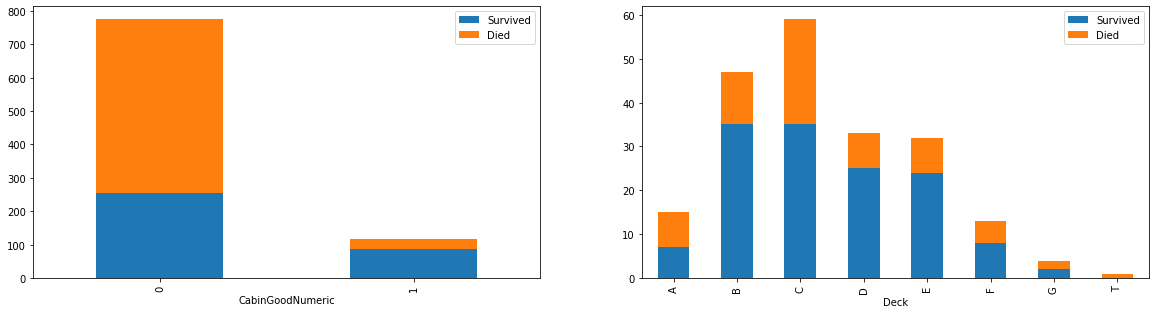

In [11]:
t_train['Deck'] = \
    t_train['Cabin'].map(lambda cabin: cabin[0] if (type(cabin) == str) else "U")

f, (ax1, ax2) = plt.subplots(1, 2, False, figsize=(20,5))

# simply having s cabin assigned increases chances of survival
t_train['CabinGoodNumeric'] =  t_train['Deck'].map(lambda letter: 1 if (letter in "BDEG") else 0)
t_train_orig.groupby('CabinGoodNumeric').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked='true', ax=ax1)

# correlate deck with survival rate for assigned cabins
import string
t_train_orig[t_train_orig['Deck'] != 'U'].groupby('Deck').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked='true', ax=ax2)

# CabinGoodNumeric doesn't yet seem to inprove things.. can it be made to be useful?
# why is it not a very important feature according to random forrest.. is it because most people don't have a cabin?

{'bodies': [<matplotlib.collections.PolyCollection at 0x124149c50>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x124137cf8>,
 'cmins': <matplotlib.collections.LineCollection at 0x124149eb8>,
 'cbars': <matplotlib.collections.LineCollection at 0x124157080>}

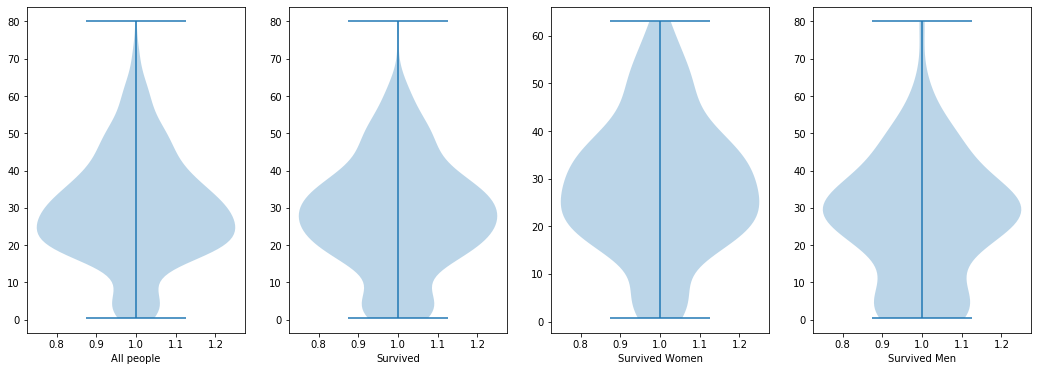

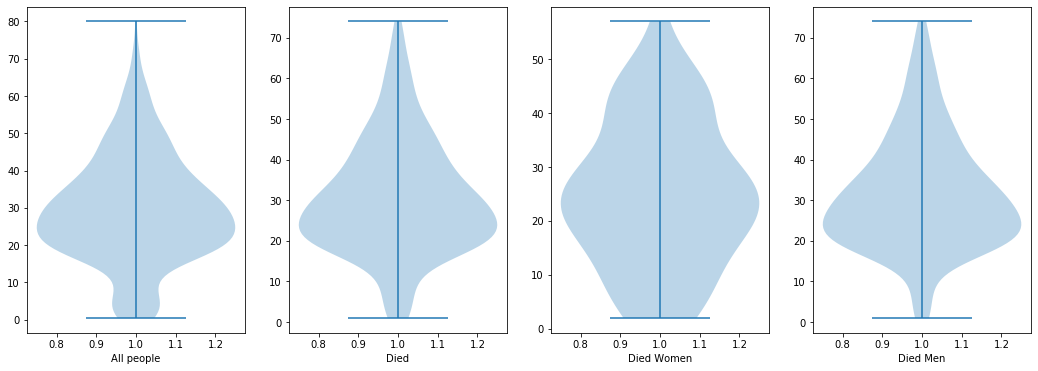

In [12]:
f, ax = plt.subplots(1, 4, sharex='col', figsize=(18,6))
age_data = t_train[['Age', 'SexNumeric', 'Survived']].dropna()
ax[0].set_xlabel('All people')
ax[0].violinplot(dataset=age_data['Age'])
ax[1].set_xlabel('Survived')
ax[1].violinplot(dataset=age_data[age_data['Survived'] == 1]['Age'])
ax[2].set_xlabel('Survived Women')
ax[2].violinplot(dataset=age_data[(age_data['Survived'] == 1) & (age_data['SexNumeric'] == 1)]['Age'])
ax[3].set_xlabel('Survived Men')
ax[3].violinplot(dataset=age_data[(age_data['Survived'] == 1) & (age_data['SexNumeric'] == 0)]['Age'])

f2, ax2 = plt.subplots(1, 4, sharex='col', figsize=(18,6))
ax2[0].set_xlabel('All people')
ax2[0].violinplot(dataset=age_data['Age'])
ax2[1].set_xlabel('Died')
ax2[1].violinplot(dataset=age_data[age_data['Survived'] == 0]['Age'])
ax2[2].set_xlabel('Died Women')
ax2[2].violinplot(dataset=age_data[(age_data['Survived'] == 0) & (age_data['SexNumeric'] == 1)]['Age'])
ax2[3].set_xlabel('Died Men')
ax2[3].violinplot(dataset=age_data[(age_data['Survived'] == 0) & (age_data['SexNumeric'] == 0)]['Age'])

### Using OneHotEncoding

In [13]:
feature_cols_ohe = ['FareAdjusted', 'Pclass', 'SexNumeric', 'Title', 'Deck']
X_ohe = t_train[feature_cols_ohe]

X_ohe = pd.concat([X_ohe,pd.get_dummies(X_ohe['Title'], prefix='Title')],axis=1).drop('Title', axis=1)
X_ohe = pd.concat([X_ohe,pd.get_dummies(X_ohe['Deck'], prefix='Deck')],axis=1).drop('Deck', axis=1)

# drop features that got a 0.0000 importance 
X_ohe = X_ohe.drop(['Title_Countess.', 'Deck_T', 'Title_Ms.', 'Title_Sir.', 'Title_Don.', 'Title_Capt.', 'Title_Col.', 'Title_Mlle.', 'Title_Major.', 'Title_Lady.', 'Title_Jonkheer.', 'Title_Mme.'] 
, axis=1)
X_ohe

,FareAdjusted,Pclass,SexNumeric,Title_Dr.,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rev.,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_U
0,7.2500,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,71.2833,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,7.9250,3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,53.1000,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,8.0500,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,13.0000,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
887,30.0000,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
888,23.4500,3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
889,30.0000,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


### apply Random Forrest Classifier to the features


In [14]:
from sklearn.ensemble import RandomForestClassifier

X_re = X_ohe
y_re = t_train.Survived

X_train, X_test, y_train, y_test = train_test_split(X_re, y_re, test_size=0.25, random_state=1)

rfc = RandomForestClassifier(n_estimators=4000,
                             min_samples_split=3, min_samples_leaf=3, max_depth=15,
                             max_features=0.85, n_jobs=-1)
rfc.fit(X_train,y_train) 

print(f'feature importance: {rfc.feature_importances_}')
print(f'score train: {rfc.score(X_train, y_train)}')
print(f'score:       {rfc.score(X_test, y_test)}')


feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_re.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances

feature importance: [2.70008197e-01 1.20540602e-01 1.19237618e-01 2.87911198e-03
 3.08990068e-02 5.05082139e-03 3.65770492e-01 7.14198835e-03
 1.47969994e-02 1.73531204e-03 5.85485245e-03 5.22736357e-03
 3.82622259e-03 1.18672183e-02 6.19776714e-04 9.66509126e-05
 3.44477668e-02]
score train: 0.8817365269461078
score:       0.8340807174887892


,importance
Title_Mr.,0.365770
FareAdjusted,0.270008
Pclass,0.120541
SexNumeric,0.119238
Deck_U,0.034448
Title_Master.,0.030899
Title_Rev.,0.014797
Deck_E,0.011867
Title_Mrs.,0.007142
Deck_B,0.005855


## Using Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression

feature_cols = ['FareAdjusted', 'Pclass', 'SexNumeric', 'TitleNumeric']

X_lr = t_train[feature_cols]
y_lr = t_train.Survived
X_train, X_test, y_train, y_test = train_test_split(X_lr, y_lr, test_size=0.25, random_state=1) # 70% training and 30% test

lr = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train, y_train)
prob = lr.predict_proba(X_lr)

print(f'probabilty (count = {len(prob)}\n{prob}\n')
print(f'score: {clf.score(X_test, y_test)}')


probabilty (count = 891
[[0.93191471 0.06808529]
 [0.11022188 0.88977812]
 [0.40116983 0.59883017]
 ...
 [0.40131613 0.59868387]
 [0.64606079 0.35393921]
 [0.93191595 0.06808405]]

score: 0.8385650224215246


## Using K-Nearest Neighbors
because.. why not?

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[118  10]
 [ 37  58]]
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       128
           1       0.85      0.61      0.71        95

    accuracy                           0.79       223
   macro avg       0.81      0.77      0.77       223
weighted avg       0.80      0.79      0.78       223

